## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import joblib

np.random.seed(42)

In [2]:
# This script expects the processed parquet produced by the previous notebook
in_fp = 'processed_train_uci.parquet'
df = pd.read_parquet(in_fp)
print(f"Loaded dataset with shape: {df.shape}")

# Ensure categorical columns are properly typed for LightGBM
categorical_cols = ['StoreType', 'Assortment', 'PromoInterval']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Ensure Date exists in dataframe
if 'Date' not in df.columns:
    raise RuntimeError('Date column not found in processed dataframe.')

Loaded dataset with shape: (1554, 35)


## Define Features and Target

In [3]:
exclude_cols = ['Sales', 'Customers', 'Date', 'CompetitionOpenDate', 'Promo2SinceDate']
features = [col for col in df.columns if col not in exclude_cols]

print(f"Training with {len(features)} features.")

X = df[features]
# Use log transform to stabilize variance
# Sales may be zero in rare cases; log1p handles zeros
y = np.log1p(df['Sales'])

Training with 32 features.


## Temporal Train-Test Split

In [7]:
# Use last 42 days as validation (similar to Rossmann notebook)
cutoff_date = df['Date'].max() - pd.to_timedelta('42 days')

print(f"Cutoff date for validation: {cutoff_date.date()}")

train_mask = df['Date'] <= cutoff_date
test_mask = df['Date'] > cutoff_date

X_train = X[train_mask].drop(columns=['Date'], errors='ignore')
X_test = X[test_mask].drop(columns=['Date'], errors='ignore')

y_train = y[train_mask]
y_test = y[test_mask]

# Convert 'Store' column to categorical
X_train['Store'] = X_train['Store'].astype('category')
X_test['Store'] = X_test['Store'].astype('category')

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Cutoff date for validation: 2011-10-28
Train shape: (1313, 32)
Test shape: (241, 32)


## Hyperparameter Tuning with Optuna

In [8]:
# Use a small number of trials by default for speed; increase for production

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        categorical_feature=['Store'],  # specify categorical column(s)
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
        
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

# Create study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Best trial params:', study.best_trial.params)

# Save study
joblib.dump(study, 'optuna_study.pkl')

[I 2025-12-06 18:44:03,237] A new study created in memory with name: no-name-1a761b94-c4c3-4a8d-9b7c-3e962b7b5a5c
[I 2025-12-06 18:44:03,416] Trial 0 finished with value: 0.6063332933853858 and parameters: {'learning_rate': 0.015213755427368948, 'num_leaves': 235, 'max_depth': 4, 'subsample': 0.7697353413758512, 'colsample_bytree': 0.603607462430112, 'min_child_samples': 24}. Best is trial 0 with value: 0.6063332933853858.
[I 2025-12-06 18:44:03,493] Trial 1 finished with value: 0.5948566772455113 and parameters: {'learning_rate': 0.07507962655984643, 'num_leaves': 150, 'max_depth': 7, 'subsample': 0.986398530722855, 'colsample_bytree': 0.9428916397370574, 'min_child_samples': 148}. Best is trial 1 with value: 0.5948566772455113.
[I 2025-12-06 18:44:03,553] Trial 2 finished with value: 0.622231046953826 and parameters: {'learning_rate': 0.027279720456728766, 'num_leaves': 126, 'max_depth': 3, 'subsample': 0.7578695690254065, 'colsample_bytree': 0.922422130020937, 'min_child_samples': 2

Best trial params: {'learning_rate': 0.09047161772470891, 'num_leaves': 185, 'max_depth': 12, 'subsample': 0.949152581434688, 'colsample_bytree': 0.8331292874938255, 'min_child_samples': 91}


['optuna_study.pkl']

## Train Final Model with Best Params

In [9]:
best_params = study.best_trial.params
best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 2000,
    'random_state': 42
})

final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

# Save final model
joblib.dump(final_model, 'lgbm_final_model.pkl')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	valid_0's rmse: 0.583891


['lgbm_final_model.pkl']

## Evaluation and Feature Importance

Final Test RMSPE: 0.7567


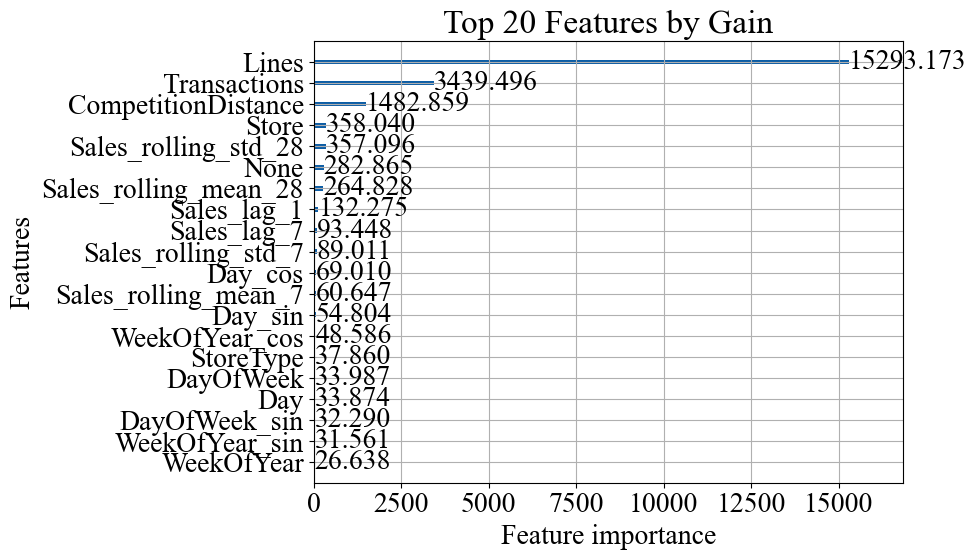

Saved predictions to test_predictions.parquet


In [10]:
log_preds = final_model.predict(X_test)

# Reverse log transform
y_test_actual = np.expm1(y_test)
preds_actual = np.expm1(log_preds)

# Compute RMSPE safely (avoid division by zero)
mask = y_test_actual > 0
if mask.sum() == 0:
    rmspe = np.nan
else:
    rmspe = np.sqrt(np.mean(((y_test_actual[mask] - preds_actual[mask]) / y_test_actual[mask]) ** 2))

print(f"Final Test RMSPE: {rmspe:.4f}")

# Plot feature importance
ax = lgb.plot_importance(final_model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title('Top 20 Features by Gain')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Save predictions for inspection
pred_df = X_test.copy()
pred_df['y_true'] = y_test_actual
pred_df['y_pred'] = preds_actual
pred_df.to_parquet('test_predictions.parquet', index=False)
print('Saved predictions to test_predictions.parquet')